<a href="https://colab.research.google.com/github/RecoHut-Projects/notebooks/blob/master/_notebooks/T417300_ALS_on_Retail_Product_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [ ]:
!pip install -q implicit

In [ ]:
!git clone https://github.com/RecoHut-Stanzas/S593234
%cd S593234

In [ ]:
import sys
sys.path.insert(0, './code')

In [ ]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy.sparse import csr_matrix
from scipy.spatial.distance import cdist
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from metrics import precision_at_k, recall_at_k

import warnings
warnings.filterwarnings('ignore')

In [ ]:
data = pd.read_parquet('./data/bronze/transactions.parquet.gzip')
data.head()

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


In [ ]:
data.columns = [col.lower() for col in data.columns]
data.rename(columns={'household_key': 'user_id',
                    'product_id': 'item_id'},
           inplace=True)


test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

data_train.head(10)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0
5,2375,26984851516,1,826249,2,1.98,364,-0.60,1642,1,0.0,0.0
6,2375,26984851516,1,1043142,1,1.57,364,-0.68,1642,1,0.0,0.0
7,2375,26984851516,1,1085983,1,2.99,364,-0.40,1642,1,0.0,0.0
8,2375,26984851516,1,1102651,1,1.89,364,0.00,1642,1,0.0,0.0
9,2375,26984851516,1,6423775,1,2.00,364,-0.79,1642,1,0.0,0.0


In [ ]:
item_features = pd.read_parquet('./data/bronze/products.parquet.gzip')
item_features.columns = [col.lower() for col in item_features.columns]
item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
item_features.head()

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ


In [ ]:
item_features.department.unique()

array(['GROCERY', 'MISC. TRANS.', 'PASTRY', 'DRUG GM', 'MEAT-PCKGD',
       'SEAFOOD-PCKGD', 'PRODUCE', 'NUTRITION', 'DELI', 'COSMETICS',
       'MEAT', 'FLORAL', 'TRAVEL & LEISUR', 'SEAFOOD', 'MISC SALES TRAN',
       'SALAD BAR', 'KIOSK-GAS', 'ELECT &PLUMBING', 'GRO BAKERY',
       'GM MERCH EXP', 'FROZEN GROCERY', 'COUP/STR & MFG', 'SPIRITS',
       'GARDEN CENTER', 'TOYS', 'CHARITABLE CONT', 'RESTAURANT', 'RX',
       'PROD-WHS SALES', 'MEAT-WHSE', 'DAIRY DELI', 'CHEF SHOPPE', 'HBC',
       'DELI/SNACK BAR', 'PORK', 'AUTOMOTIVE', 'VIDEO RENTAL', ' ',
       'CNTRL/STORE SUP', 'HOUSEWARES', 'POSTAL CENTER', 'PHOTO', 'VIDEO',
       'PHARMACY SUPPLY'], dtype=object)

In [ ]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head()

,user_id,actual
0,1,"[879517, 934369, 1115576, 1124029, 5572301, 65..."
1,3,"[823704, 834117, 840244, 913785, 917816, 93870..."
2,5,"[913077, 1118028, 1386668]"
3,6,"[825541, 859676, 999318, 1055646, 1067606, 108..."
4,7,"[929248, 948622, 1013572, 1022003, 1049892, 10..."


In [ ]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999_999

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity',
                                  aggfunc='count', 
                                  fill_value=0
                                 )
user_item_matrix = user_item_matrix.astype(float)
sparse_user_item = csr_matrix(user_item_matrix)
sparse_user_item

<2500x5001 sparse matrix of type '<class 'numpy.float64'>'
	with 709529 stored elements in Compressed Sparse Row format>

In [ ]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

## ALS

In [ ]:
model = AlternatingLeastSquares(factors=64, 
                                regularization=0.05,
                                iterations=15,  
                                calculate_training_loss=True,
                                use_gpu=False)
model.fit(csr_matrix(user_item_matrix).T.tocsr(), show_progress=True)
recs = model.recommend(userid=userid_to_id[2], 
                        user_items=csr_matrix(user_item_matrix).tocsr(),
                        N=5,
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=True)

In [ ]:
def get_recommendations(user, model, N=5):
    res = [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[user], 
                                    user_items=sparse_user_item,
                                    N=N, 
                                    filter_already_liked_items=False, 
                                    filter_items=None, 
                                    recalculate_user=True)]
    return res

In [ ]:
result['als'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
result.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean()
result.head()

,user_id,actual,als
0,1,"[879517, 934369, 1115576, 1124029, 5572301, 65...","[1100972, 965766, 1033142, 995242, 999999]"
1,3,"[823704, 834117, 840244, 913785, 917816, 93870...","[5569327, 1106523, 5568378, 883404, 910032]"
2,5,"[913077, 1118028, 1386668]","[999999, 1082185, 6534178, 1029743, 995242]"
3,6,"[825541, 859676, 999318, 1055646, 1067606, 108...","[1007195, 878996, 1024306, 986912, 866211]"
4,7,"[929248, 948622, 1013572, 1022003, 1049892, 10...","[999999, 1082185, 1058997, 938700, 1126899]"


In [ ]:
model.item_factors.shape, model.user_factors.shape

((5001, 64), (2500, 64))

In [ ]:
%%time
# we can calculate predictions very quickly by multuplying these matrices
fast_recs = model.user_factors @ model.item_factors.T 
fast_recs.shape

CPU times: user 59.2 ms, sys: 241 µs, total: 59.4 ms
Wall time: 35.7 ms


In [ ]:
fast_recs[0,:]

array([-0.00383742,  0.01107451, -0.0201415 , ...,  0.02444663,
       -0.08549848, -0.06929479], dtype=float32)

### Embeddings visualization

In [ ]:
def reduce_dims(df, dims=2, method='pca'):
    
    assert method in ['pca', 'tsne'], 'Неверно указан метод'
    
    if method=='pca':
        pca = PCA(n_components=dims)
        components = pca.fit_transform(df)
    elif method == 'tsne':
        tsne = TSNE(n_components=dims, learning_rate=250, random_state=42)
        components = tsne.fit_transform(df)
    else:
        print('Error')
        
    colnames = ['component_' + str(i) for i in range(1, dims+1)]
    return pd.DataFrame(data = components, columns = colnames) 

In [ ]:
def display_components_in_2D_space(components_df, labels='category', marker='D'):
    
    groups = components_df.groupby(labels)

    # Plot
    fig, ax = plt.subplots(figsize=(12,8))
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
    for name, group in groups:
        ax.plot(group.component_1, group.component_2, 
                marker='o', ms=6,
                linestyle='',
                alpha=0.7,
                label=name)
    ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5))

    plt.xlabel('component_1')
    plt.ylabel('component_2') 
    plt.show()

In [ ]:
model.item_factors.shape

(5001, 64)

In [ ]:
category = []

for idx in range(model.item_factors.shape[0]):
    try:
        cat = item_features.loc[item_features['item_id'] == id_to_itemid[idx], 'department'].values[0]
        category.append(cat)
    except:
        category.append('UNKNOWN')
        
print(category[:10])

['MISC SALES TRAN', 'KIOSK-GAS', 'MISC SALES TRAN', 'KIOSK-GAS', 'MISC SALES TRAN', 'MISC SALES TRAN', 'KIOSK-GAS', 'GROCERY', 'GROCERY', 'GROCERY']


In [ ]:
item_emb_tsne = reduce_dims(model.item_factors, dims=2, method='tsne') # 5001 х 64  ---> 5001 x 2
item_emb_tsne['category'] = category
item_emb_tsne = item_emb_tsne[item_emb_tsne['category'] != 'UNKNOWN']

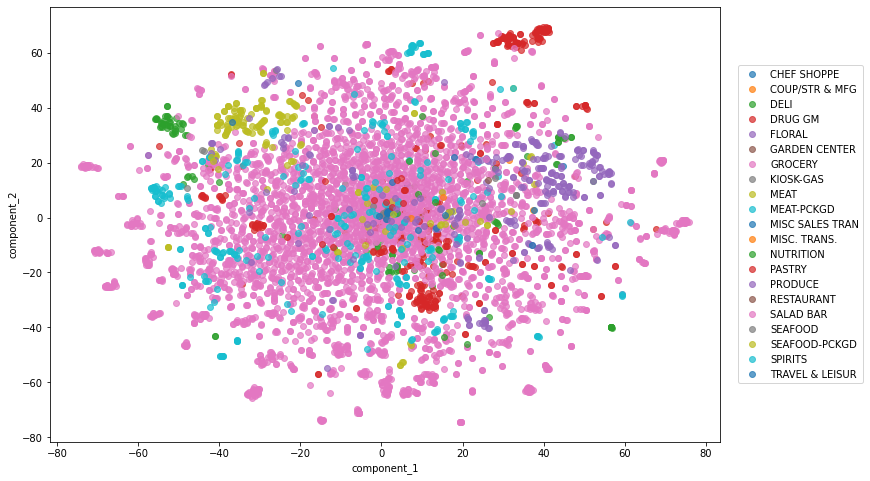

In [ ]:
display_components_in_2D_space(item_emb_tsne, labels='category')

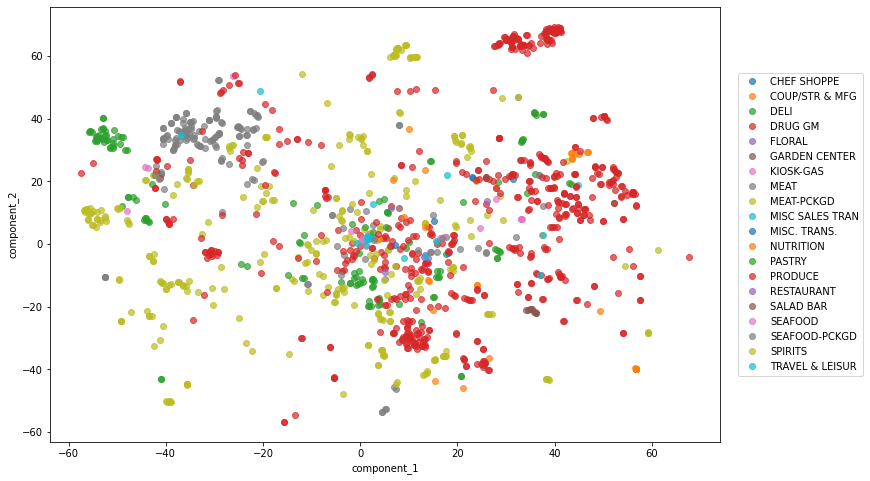

In [ ]:
# grocery taking lots of points in this space
# let's draw again without grocery to get more clear picture
display_components_in_2D_space(item_emb_tsne[item_emb_tsne['category'] != 'GROCERY'], labels='category')

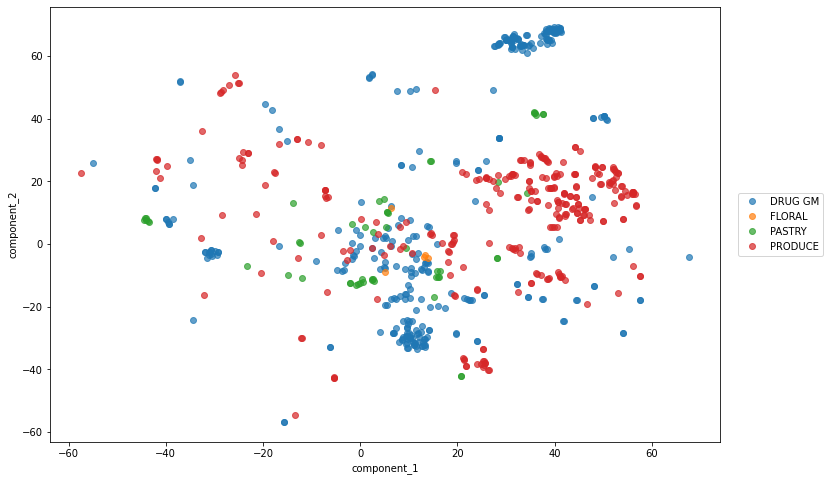

In [ ]:
# let's draw some specific categories
interesting_catgs = ['PASTRY', 'PRODUCE', 'DRUG GM', 'FLORAL']
display_components_in_2D_space(item_emb_tsne[item_emb_tsne['category'].isin(interesting_catgs)], 
                                             labels='category')

### Similar items

In [ ]:
example_item_row_id = 3606
closest_items = [id_to_itemid[row_id] for row_id, score in model.similar_items(example_item_row_id, N=5)]
item_features[item_features.item_id.isin(closest_items)]

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
5915,819978,3544,DELI,National,CHEESES,CHEESE: PROCESSED BULK,
18923,933835,3705,DELI,National,DELI MEATS,MEAT: SAUS DRY BULK,
28449,1018740,3516,DELI,National,DELI MEATS,MEAT:HAM BULK,
30927,1040807,3544,DELI,National,CHEESES,CHEESE: PROCESSED BULK,
37665,1101010,3862,DELI,National,DELI MEATS,MEAT: LUNCHMEAT BULK,


### Similar users

In [ ]:
model.similar_users(userid_to_id[10], N=5)

[(9, 0.99999994),
 (790, 0.9827203),
 (354, 0.9777084),
 (1380, 0.9761078),
 (1681, 0.97573155)]

## TF-IDF weighting

In [ ]:
user_item_matrix = tfidf_weight(user_item_matrix.T).T

model = AlternatingLeastSquares(factors=64, 
                                regularization=0.05,
                                iterations=15, 
                                calculate_training_loss=True,
                                use_gpu=False)

model.fit(csr_matrix(user_item_matrix).T.tocsr(), show_progress=True)

result['als_tfidf'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
print(result.apply(lambda row: precision_at_k(row['als_tfidf'], row['actual']), axis=1).mean())

result.head()


0.17187343043696385


,user_id,actual,als,als_tfidf
0,1,"[879517, 934369, 1115576, 1124029, 5572301, 65...","[1100972, 965766, 1033142, 995242, 999999]","[999999, 1082185, 995242, 1005186, 911812]"
1,3,"[823704, 834117, 840244, 913785, 917816, 93870...","[5569327, 1106523, 5568378, 883404, 910032]","[999999, 1029743, 951590, 856772, 952317]"
2,5,"[913077, 1118028, 1386668]","[999999, 1082185, 6534178, 1029743, 995242]","[999999, 1082185, 1029743, 995242, 6534178]"
3,6,"[825541, 859676, 999318, 1055646, 1067606, 108...","[1007195, 878996, 1024306, 986912, 866211]","[1023720, 965267, 999999, 1082185, 1024306]"
4,7,"[929248, 948622, 1013572, 1022003, 1049892, 10...","[999999, 1082185, 1058997, 938700, 1126899]","[999999, 1082185, 6534178, 1029743, 995242]"


## BM25 weighting

In [ ]:
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999
user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity',
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float)
sparse_user_item = csr_matrix(user_item_matrix).tocsr()
user_item_matrix = bm25_weight(user_item_matrix.T).T 

model = AlternatingLeastSquares(factors=64, 
                                regularization=0.05,
                                iterations=15, 
                                calculate_training_loss=True, 
                                use_gpu=False)

model.fit(csr_matrix(user_item_matrix).T.tocsr(), show_progress=True)

result['als_bm25'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
print(result.apply(lambda row: precision_at_k(row['als_bm25'], row['actual']), axis=1).mean())
result.head(2)


0.17267704671019338


,user_id,actual,als,als_tfidf,als_bm25
0,1,"[879517, 934369, 1115576, 1124029, 5572301, 65...","[1100972, 965766, 1033142, 995242, 999999]","[999999, 1082185, 995242, 1005186, 911812]","[999999, 1100972, 995242, 1082185, 934369]"
1,3,"[823704, 834117, 840244, 913785, 917816, 93870...","[5569327, 1106523, 5568378, 883404, 910032]","[999999, 1029743, 951590, 856772, 952317]","[999999, 951590, 1133018, 892008, 1075470]"


---

In [ ]:
!pip install -q watermark
%reload_ext watermark
%watermark -a "Sparsh A." -m -iv -u -t -d -p implicit

Author: Sparsh A.

Last updated: 2021-12-05 13:59:10

implicit: 0.4.8

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.4.104+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

matplotlib: 3.2.2
IPython   : 5.5.0
numpy     : 1.19.5
sys       : 3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
pandas    : 1.1.5



---

**END**